Graphs to make:
- [V] 1. Lissajous overview
- [ ] 2. Single representative Lissajous
- [V] 3. Current/Voltage profile overview
- [ ] 4. Single representative current/voltage profile

Step 0: import libraries and create static variables

In [162]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import numpy as np
from matplotlib.patches import FancyArrowPatch

In [163]:
# Define the alpha value for the post-plasma materials
alpha = 0.75

# Define the color for each material
packing_colors = {
    'SiO₂ Type S': (0/255, 0/255, 0/255),
    'SiO₂ - HT Etched': (86/255, 180/255, 233/255),
    'GM10.3': (0/255, 114/255, 178/255),
    'GM10.4': (230/255, 159/255, 0/255),
    'GM11.2': (213/255, 94/255, 0/255),
    'SiO₂/TMAH/2-PrOH 9h Etched': (204/255, 121/255, 167/255),
    'SiO₂/TMAH 3h Etched': (0/255, 158/255, 115/255)
}

# determine order of materials for plotting
packing_order = [
    'SiO₂ Type S',
    'SiO₂ - HT Etched',
    'GM10.3',
    'GM10.4',
    'GM11.2',
    'SiO₂/TMAH/2-PrOH 9h Etched',
    'SiO₂/TMAH 3h Etched'
]

t_quantile = stats.t.ppf(1 - 0.05/2, 7)

In [164]:
# Use Times New Roman font
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.rm'] = 'Times New Roman'
plt.rcParams['mathtext.it'] = 'Times New Roman:italic'
plt.rcParams['mathtext.bf'] = 'Times New Roman:bold'

# Set font size
plt.rcParams['font.size'] = 7

In [165]:
# set the folder and file name
folder_path = r'N:\FWET\FDCH\AdsCatal\General\personal_work_folders\plasmacatdesign\co2-splitting\uhasselt'

Step 1: Import & prepare calculated electrical data

In [166]:
file_name = 'uhasselt_co2_spl_electrical_data_combined.csv'
file_path = os.path.join(folder_path, file_name)

# read the Excel file
df = pd.read_csv(file_path)

In [167]:
df_mean = df[
    (df['residence_time_s'] <= 80) &
    (df['plasma_state'] == 'plasma')
].query(
    'material_name in ["Glass_Beads_HT", "GM10.3", "GM10.4", "GM11.2", "SiO2+TMAH+2-PrOH-220-09H", "SiO2+TMAH-220-03H"]'
).assign(
    material_name=lambda x: x['material_name'].map(
        {
            'Glass_Beads_HT': "SiO₂ - HT Etched",
            'GM10.3': 'GM10.3',
            'GM10.4': 'GM10.4',
            'GM11.2': 'GM11.2',
            'SiO2+TMAH+2-PrOH-220-09H': 'SiO₂/TMAH/2-PrOH 9h Etched',
            'SiO2+TMAH-220-03H': 'SiO₂/TMAH 3h Etched',
        }
    ),
    U_pp_kV=lambda x: x['U_pp_V'] / 1000,
    displaced_charge_nC=lambda x: x['displaced_charge_C'] * 1e9,
    sei_kjmol=lambda x: (x['plasma_power_W'] / 
                         (
                          (1 - 0.4774) *
                          (17.31 / x['residence_time_s'])
                         ) * 24.055
                        ),
    plasma_rms_current_mA=lambda x: x['plasma_rms_current_A'] * 1e3,
    sei_ideal_kjmol=lambda x: round(
        number=30 / ((1 - 0.4774) * (17.31 / x['residence_time_s'])) * 24.055,
        ndigits=-1
    ).astype(int),
    eff_cap_pF=lambda x: x['slope_DA_F'] * 1e12
).groupby(
    ['material_name', 'sei_ideal_kjmol']
).agg(
    U_pp_kV=('U_pp_kV', 'mean'),
    U_pp_kV_err=(
        'U_pp_kV',
        lambda x: stats.t.ppf(1 - 0.05/2, len(x)) * x.sem()
    ),
    avg_num_udisch_per_graph=('avg_num_udisch_per_graph', 'mean'),
    avg_num_udisch_per_graph_err=(
        'avg_num_udisch_per_graph',
        lambda x: stats.t.ppf(1 - 0.05/2, len(x)) * x.sem()
    ),
    displaced_charge_nC=('displaced_charge_nC', 'mean'),
    displaced_charge_nC_err=(
        'displaced_charge_nC',
        lambda x: stats.t.ppf(1 - 0.05/2, len(x)) * x.sem()
    ),
    plasma_rms_current_mA=('plasma_rms_current_mA', 'mean'),
    plasma_rms_current_mA_err=(
        'plasma_rms_current_mA',
        lambda x: stats.t.ppf(1 - 0.05/2, len(x)) * x.sem()
    ),
    eff_cap_pF=('eff_cap_pF', 'mean'),
    eff_cap_pF_err=(
        'eff_cap_pF',
        lambda x: stats.t.ppf(1 - 0.05/2, len(x)) * x.sem()
    )
).reset_index(
).copy()

Step 1.1: U_pp vs SEI

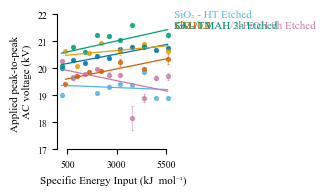

In [168]:
# Create a scatter plot with a linear regression line for each material_name
g = sns.lmplot(
    x="sei_ideal_kjmol",
    y="U_pp_kV",
    data=df_mean,
    hue="material_name",
    hue_order=packing_order,
    palette=packing_colors,
    height=5/2.54,
    aspect=1.66,
    order=1,
    ci=None,
    legend=False,
    scatter_kws={"s": 8, "alpha": alpha},
    line_kws={"lw": 0.9}
)

g.set_xlabels("Specific Energy Input (kJ  mol⁻¹)", fontsize=8)
g.set_ylabels("Applied peak-to-peak \n AC voltage (kV)", fontsize=8)

ax = g.axes.flatten()[0]

for packing in df_mean['material_name'].unique():
    subset = df_mean[df_mean['material_name'] == packing]
    ax.errorbar(
        x=subset['sei_ideal_kjmol'],
        y=subset['U_pp_kV'],
        yerr=subset['U_pp_kV_err'],
        fmt='none',
        ecolor=packing_colors[packing],
        elinewidth=0.5,
        capsize=1,
        capthick=0.95,
        alpha=0.6
    )

# Define the label points manually
label_points = {
    'SiO₂ - HT Etched': (5700, 21.9),
    'GM10.3': (5700, 21.5),
    'GM10.4': (5700, 21.5),
    'GM11.2': (5700, 21.5),
    'SiO₂/TMAH/2-PrOH 9h Etched': (5700, 21.5),
    'SiO₂/TMAH 3h Etched': (5700, 21.5)
}

# Loop through each item in label_points
# and add a text label with an offset
for material, (x, y) in label_points.items():
    ax.annotate(
        text=material,
        xy=(x, y),
        xytext=(3,0),
        textcoords='offset points',
        fontsize=8,
        color=packing_colors[material]
    )

ax.set_xlim(-25, 5700)
ax.spines['bottom'].set_bounds(500, 5500)
ax.set_xticks(ticks=[500, 3000, 5500])

ax.set_ylim(17, 22)
ax.spines['left'].set_bounds(17, 22)

plt.tight_layout()
plt.savefig(
    r"C:\Users\sbossier\Dropbox\Apps\Overleaf\ladca_desine_paper_etching\figs\sander_U_pp_vs_sei.pdf",
    bbox_inches='tight'
)
plt.show()

Step 1.2: displ Q vs SEI

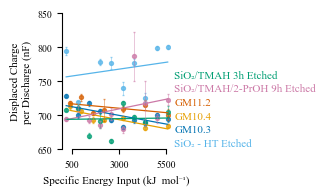

In [169]:
# Create a scatter plot with a linear regression line for each material_name
g = sns.lmplot(
    x="sei_ideal_kjmol",
    y="displaced_charge_nC",
    data=df_mean,
    hue="material_name",
    hue_order=packing_order,
    palette=packing_colors,
    height=5/2.54,
    aspect=1.66,
    order=1,
    ci=None,
    legend=False,
    scatter_kws={"s": 8, "alpha": alpha},
    line_kws={"lw": 0.9}
)

g.set_xlabels("Specific Energy Input (kJ  mol⁻¹)", fontsize=8)
g.set_ylabels("Displaced Charge\nper Discharge (nF)", fontsize=8)

ax = g.axes.flatten()[0]

for packing in df_mean['material_name'].unique():
    subset = df_mean[df_mean['material_name'] == packing]
    ax.errorbar(
        x=subset['sei_ideal_kjmol'],
        y=subset['displaced_charge_nC'],
        yerr=subset['displaced_charge_nC_err'],
        fmt='none',
        ecolor=packing_colors[packing],
        elinewidth=0.5,
        capsize=1,
        capthick=0.95,
        alpha=0.6
    )

# Define the label points manually
label_points = {
    'SiO₂ - HT Etched': (5700, 655),
    'GM10.3': (5700, 675),
    'GM10.4': (5700, 695),
    'GM11.2': (5700, 715),
    'SiO₂/TMAH/2-PrOH 9h Etched': (5700, 735),
    'SiO₂/TMAH 3h Etched': (5700, 755)
}

# Loop through each item in label_points
# and add a text label with an offset
for material, (x, y) in label_points.items():
    ax.annotate(
        text=material,
        xy=(x, y),
        xytext=(3,0),
        textcoords='offset points',
        fontsize=8,
        color=packing_colors[material]
    )

ax.set_xlim(-25, 5700)
ax.spines['bottom'].set_bounds(500, 5500)
ax.set_xticks(ticks=[500, 3000, 5500])

ax.set_ylim(650, 850)
ax.spines['left'].set_bounds(650, 850)

plt.tight_layout()
plt.savefig(
    r"C:\Users\sbossier\Dropbox\Apps\Overleaf\ladca_desine_paper_etching\figs\sander_displ_Q_vs_sei.pdf",
    bbox_inches='tight'
)
plt.show()

Step 1.3: rms reactor I vs sei

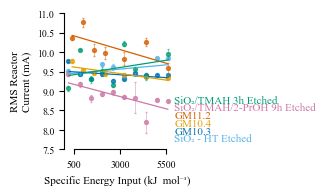

In [170]:
# Create a scatter plot with a linear regression line for each material_name
g = sns.lmplot(
    x="sei_ideal_kjmol",
    y="plasma_rms_current_mA",
    data=df_mean,
    hue="material_name",
    hue_order=packing_order,
    palette=packing_colors,
    height=5/2.54,
    aspect=1.66,
    order=1,
    ci=None,
    legend=False,
    scatter_kws={"s": 8, "alpha": alpha},
    line_kws={"lw": 0.9}
)

g.set_xlabels("Specific Energy Input (kJ  mol⁻¹)", fontsize=8)
g.set_ylabels("RMS Reactor\nCurrent (mA)", fontsize=8)

ax = g.axes.flatten()[0]

for packing in df_mean['material_name'].unique():
    subset = df_mean[df_mean['material_name'] == packing]
    ax.errorbar(
        x=subset['sei_ideal_kjmol'],
        y=subset['plasma_rms_current_mA'],
        yerr=subset['plasma_rms_current_mA_err'],
        fmt='none',
        ecolor=packing_colors[packing],
        elinewidth=0.5,
        capsize=1,
        capthick=0.95,
        alpha=0.6
    )

# Define the label points manually
label_points = {
    'SiO₂ - HT Etched': (5700, 7.7),
    'GM10.3': (5700, 7.9),
    'GM10.4': (5700, 8.1),
    'GM11.2': (5700, 8.3),
    'SiO₂/TMAH/2-PrOH 9h Etched': (5700, 8.5),
    'SiO₂/TMAH 3h Etched': (5700, 8.7)
}

# Loop through each item in label_points
# and add a text label with an offset
for material, (x, y) in label_points.items():
    ax.annotate(
        text=material,
        xy=(x, y),
        xytext=(3,0),
        textcoords='offset points',
        fontsize=8,
        color=packing_colors[material]
    )

ax.set_xlim(-25, 5700)
ax.spines['bottom'].set_bounds(500, 5500)
ax.set_xticks(ticks=[500, 3000, 5500])

ax.set_ylim(7.5, 11)
ax.spines['left'].set_bounds(7.5, 11)

plt.tight_layout()
plt.savefig(
    r"C:\Users\sbossier\Dropbox\Apps\Overleaf\ladca_desine_paper_etching\figs\sander_rms_reactor_I_vs_sei.pdf",
    bbox_inches='tight'
)
plt.show()

Step 1.4: avg_num_udisch vs sei

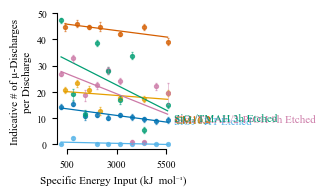

In [171]:
# Create a scatter plot with a linreg line for each material_name
g = sns.lmplot(
    x="sei_ideal_kjmol",
    y="avg_num_udisch_per_graph",
    data=df_mean,
    hue="material_name",
    hue_order=packing_order,
    palette=packing_colors,
    height=5/2.54,
    aspect=1.66,
    order=1,
    ci=None,
    legend=False,
    scatter_kws={"s": 8, "alpha": alpha},
    line_kws={"lw": 0.9}
)

g.set_xlabels("Specific Energy Input (kJ  mol⁻¹)", fontsize=8)
g.set_ylabels("Indicative # of µ-Discharges\nper Discharge", fontsize=8)

ax = g.axes.flatten()[0]

for packing in df_mean['material_name'].unique():
    subset = df_mean[df_mean['material_name'] == packing]
    ax.errorbar(
        x=subset['sei_ideal_kjmol'],
        y=subset['avg_num_udisch_per_graph'],
        yerr=subset['avg_num_udisch_per_graph_err'],
        fmt='none',
        ecolor=packing_colors[packing],
        elinewidth=0.5,
        capsize=1,
        capthick=0.95,
        alpha=0.6
    )

# Define the label points manually
label_points = {
    'SiO₂ - HT Etched': (5700, 7.7),
    'GM10.3': (5700, 7.9),
    'GM10.4': (5700, 8.1),
    'GM11.2': (5700, 8.3),
    'SiO₂/TMAH/2-PrOH 9h Etched': (5700, 8.5),
    'SiO₂/TMAH 3h Etched': (5700, 8.7)
}

# Loop through each item in label_points
# and add a text label with an offset
for material, (x, y) in label_points.items():
    ax.annotate(
        text=material,
        xy=(x, y),
        xytext=(3,0),
        textcoords='offset points',
        fontsize=8,
        color=packing_colors[material]
    )

ax.set_xlim(-25, 5700)
ax.spines['bottom'].set_bounds(500, 5500)
ax.set_xticks(ticks=[500, 3000, 5500])

ax.set_ylim(-2, 50)
ax.spines['left'].set_bounds(0, 50)

plt.tight_layout()
plt.savefig(
    r"C:\Users\sbossier\Dropbox\Apps\Overleaf\ladca_desine_paper_etching\figs\sander_avg_num_udisch_vs_sei.pdf",
    bbox_inches='tight'
)
plt.show()

Step 1.5: eff_cap vs sei

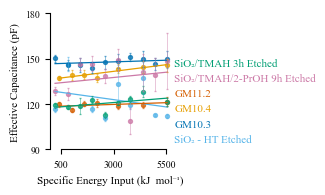

In [177]:
# Create a scatter plot with a linreg line for each material_name
g = sns.lmplot(
    x="sei_ideal_kjmol",
    y="eff_cap_pF",
    data=df_mean,
    hue="material_name",
    hue_order=packing_order,
    palette=packing_colors,
    height=5/2.54,
    aspect=1.66,
    order=1,
    ci=None,
    legend=False,
    scatter_kws={"s": 8, "alpha": alpha},
    line_kws={"lw": 0.9}
)

g.set_xlabels("Specific Energy Input (kJ  mol⁻¹)", fontsize=8)
g.set_ylabels("Effective Capacitance (pF)", fontsize=8)

ax = g.axes.flatten()[0]

for packing in df_mean['material_name'].unique():
    subset = df_mean[df_mean['material_name'] == packing]
    ax.errorbar(
        x=subset['sei_ideal_kjmol'],
        y=subset['eff_cap_pF'],
        yerr=subset['eff_cap_pF_err'],
        fmt='none',
        ecolor=packing_colors[packing],
        elinewidth=0.5,
        capsize=1,
        capthick=0.95,
        alpha=0.6
    )

# Define the label points manually
label_points = {
    'SiO₂ - HT Etched': (5700, 95),
    'GM10.3': (5700, 105),
    'GM10.4': (5700, 115),
    'GM11.2': (5700, 125),
    'SiO₂/TMAH/2-PrOH 9h Etched': (5700, 135),
    'SiO₂/TMAH 3h Etched': (5700, 145)
}

# Loop through each item in label_points
# and add a text label with an offset
for material, (x, y) in label_points.items():
    ax.annotate(
        text=material,
        xy=(x, y),
        xytext=(3,0),
        textcoords='offset points',
        fontsize=8,
        color=packing_colors[material]
    )

ax.set_xlim(-25, 5700)
ax.spines['bottom'].set_bounds(500, 5500)
ax.set_xticks(ticks=[500, 3000, 5500])

ax.set_ylim(90, 180)
ax.spines['left'].set_bounds(90, 180)
ax.set_yticks(ticks=[90, 120, 150, 180])

plt.tight_layout()
plt.savefig(
    r"C:\Users\sbossier\Dropbox\Apps\Overleaf\ladca_desine_paper_etching\figs\sander_eff_cap_vs_sei.pdf",
    bbox_inches='tight'
)
plt.show()

Step 2: Import & prepare Lissajous data